In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
data = pd.read_csv("X_train.csv",encoding='cp1251', sep =',')

In [3]:
data = data.rename(columns={"v1":"label", "v2":"text"})

In [4]:
data.head()

,label,text
0,ham,I tot u outside cos darren say u come shopping...
1,ham,Arun can u transfr me d amt
2,ham,what are your new years plans?
3,spam,"January Male Sale! Hot Gay chat now cheaper, c..."
4,ham,Ya that one is slow as poo


In [5]:
#Count observations in each label
data.label.value_counts()

ham     3526
spam     546
Name: label, dtype: int64

In [6]:
# convert label to a numerical variable
data['label_num'] = data.label.map({'ham':0, 'spam':1})

In [7]:
data['length'] = data['text'].apply(len)
data.head()

,label,text,label_num,length
0,ham,I tot u outside cos darren say u come shopping...,0,110
1,ham,Arun can u transfr me d amt,0,27
2,ham,what are your new years plans?,0,30
3,spam,"January Male Sale! Hot Gay chat now cheaper, c...",1,155
4,ham,Ya that one is slow as poo,0,26


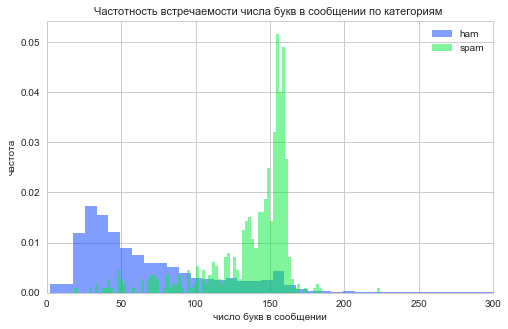

In [8]:

# Из графика видно, что длина слова является важным показателем для разделения ham от spam

import matplotlib as mpl

from pylab import *
rcParams['figure.figsize'] = 8,5
from matplotlib import rc_params
#rcParams['figure.figsize'] = 30,10
sns.set_style("whitegrid")
plt.style.use('seaborn-bright')
#data.hist(column='length', by='label', bins=50,figsize=(11,5), color= 'red')
from matplotlib import  pyplot
pyplot.hist(data[data['label']=='ham']['length'], alpha=0.5, label='ham', normed=True, bins=100)
pyplot.hist(data[data['label']=='spam']['length'], alpha=0.5, label='spam', normed=True, bins=100)
plt.xlabel('число букв в сообщении', fontsize=10)
xlim(xmax=300) # adjust the max leaving min unchanged
xlim(xmin=0)
plt.ylabel('частота',  fontsize=10)
plt.title('Частотность встречаемости числа букв в сообщении по категориям ', fontsize=11)
pyplot.legend(loc='upper right')
pyplot.show()


Populating the interactive namespace from numpy and matplotlib


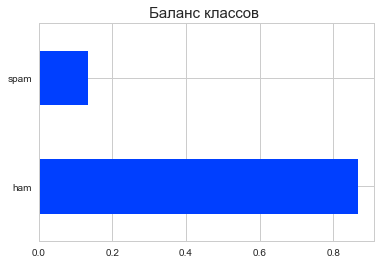

In [9]:
# Баланс классов
%pylab inline
a= data.label.value_counts()/ data.shape[0]
import pandas as pd
import matplotlib.pyplot as plt
plt.title('Баланс классов ', fontsize=15)
a.plot.barh(stacked=True);

In [10]:
a

ham     0.865914
spam    0.134086
Name: label, dtype: float64

In [11]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

### Remove stopwords

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}' ,'\\', '//', ';', ':']) 
stop_words.update([str(i) for i in range(10)])

In [13]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_words)


In [14]:
sentence = "At eight o'clock on Thursday morning Arthur didn't feel very good. French-Fries"
print(preprocess(sentence))

eight clock thursday morning arthur feel good french fries


In [15]:
data['text'] = data['text'].map(preprocess)

## Stemming 

In [16]:
import nltk
sno = nltk.stem.SnowballStemmer('english')
sno.stem('grows')

'grow'

In [17]:
def preprocess_stem(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [ sno.stem(w) for w in tokens]
    return " ".join(filtered_words)

data['text'] = data['text'].map(preprocess_stem)


## Naive Bayes

In [18]:
from scipy.sparse import csr_matrix 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:

%%time
# Нормализуем длину букв в сообщениях, чтобы поле можно было вместить в разреженную матрицу числа встречаемости слов 
len_sms = data['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 

## Создаем матрицу встречаемости слов в сообщениях+ поле с нормализованной длинной сообщения
vectorizer = CountVectorizer().fit(data.text)
X = vectorizer.transform(data.text)
X = np.hstack((X.todense(),len_sms[:, None]))

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
score = cross_val_score(cv=5, estimator=clf, X=X, y=data.label_num, scoring='roc_auc', n_jobs=-1)
print ('Kfold score list: {}'.format(score))
print ('Mean score: {:.4}'.format(np.mean(score)))
print ('Confidence interval for score: ({:.4}, {:.4})'.format(np.mean(score) - np.std(score), 
                                                    np.mean(score) + np.std(score)))

Kfold score list: [ 0.99137265  0.99092979  0.96828681  0.98335611  0.98144316]
Mean score: 0.9831
Confidence interval for score: (0.9747, 0.9915)
Wall time: 8.31 s


#### Неплохой результат. Попробуем улучшить качество беря матрицу частот - Tf- Idf

In [20]:
len_sms = data['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 

vect= TfidfVectorizer()
Z = vect.fit(data.text)
Z = vect.transform(data.text)
Z = np.hstack((Z.todense(),len_sms[:, None]))


nn = MultinomialNB()
score_tf = cross_val_score(cv=5, estimator=nn,X= Z, y=data.label_num, scoring='roc_auc', n_jobs=-1)
print ('Kfold score list: {}'.format(score_tf))
print ('Mean score: {:.4}'.format(np.mean(score_tf)))
print ('Confidence interval for score: ({:.4}, {:.4})'.format(np.mean(score_tf) - np.std(score_tf), 
                                                    np.mean(score_tf) + np.std(score_tf)))

Kfold score list: [ 0.98995622  0.9908387   0.97593858  0.98490468  0.97900969]
Mean score: 0.9841
Confidence interval for score: (0.9782, 0.99)


## Boosting

In [21]:
## Data generation with TF-Idf
len_sms = data['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 

vect= TfidfVectorizer()
Z = vect.fit(data.text)
Z = vect.transform(data.text)
Z = np.hstack((Z.todense(),len_sms[:, None]))

## Modelling
from sklearn.model_selection import cross_val_score
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.15, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=500, nthread=-1,
       objective='reg:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=130, silent=True, subsample=0.5)

score =cross_val_score(xgb_classifier, Z, y = data['label_num'].tolist(),  scoring = 'roc_auc', cv = 5)  
print ('Kfold score list: {}'.format(score))

Kfold score list: [ 0.96126062  0.94287202  0.95848787  0.95149977  0.92695686]


In [27]:
print ('Kfold score list: {}'.format(score))
print ('Mean score: {:.4}'.format(np.mean(score)))
print ('Confidence interval for score: ({:.4}, {:.4})'.format(np.mean(score) - np.std(score), 
                                                    np.mean(score) + np.std(score)))

Kfold score list: [ 0.96126062  0.94287202  0.95848787  0.95149977  0.92695686]
Mean score: 0.9482
Confidence interval for score: (0.9358, 0.9606)


## LightGBM

In [28]:
## Data generation with TF-Idf
len_sms = data['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 

vect= TfidfVectorizer()
Z = vect.fit(data.text)
Z = vect.transform(data.text)
Z = np.hstack((Z.todense(),len_sms[:, None]))

## Modelling
import xgboost as xgb
import lightgbm as lgbm
from sklearn import ensemble, cross_validation, learning_curve, metrics 
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model1 = lgbm.LGBMClassifier(num_leaves=60,learning_rate=0.01,max_depth = -1, metric = 'roc_auc', 
subsample=0.7, min_child_samples = 45, n_estimators=1000) 


## CV
scores_cv =cross_val_score(model1, Z, y=data.label_num,  scoring = 'roc_auc', cv = 5) 

## Print results
print ('Kfold score list: {}'.format(scores_cv))
print ('Mean score: {:.4}'.format(np.mean(scores_cv)))
print ('Confidence interval for score: ({:.4}, {:.4})'.format(np.mean(scores_cv) - np.std(scores_cv), 
                                                    np.mean(scores_cv) + np.std(scores_cv)))

C:\Users\somarov\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\somarov\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Kfold score list: [ 0.97674478  0.9712278   0.9666992   0.97336196  0.95731668]
Mean score: 0.9691
Confidence interval for score: (0.9624, 0.9758)


In [29]:
## Data generation with TF-Idf
len_sms = data['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 

vect= TfidfVectorizer()
Z = vect.fit(data.text)
Z = vect.transform(data.text)
Z = np.hstack((Z.todense(),len_sms[:, None]))

## Modelling
model2 = RandomForestClassifier(bootstrap=True, 
            criterion='gini', max_depth=8, max_features='auto',class_weight='balanced',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=500, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)
## CV
scores_cv =cross_val_score(model2, Z,  y=data.label_num,  scoring = 'roc_auc', cv = 5) 

## Print
print ('Kfold score list: {}'.format(scores_cv))
print ('Mean score: {:.4}'.format(np.mean(scores_cv)))
print ('Confidence interval for score: ({:.4}, {:.4})'.format(np.mean(scores_cv) - np.std(scores_cv), 
                                                    np.mean(scores_cv) + np.std(scores_cv)))

Kfold score list: [ 0.83750322  0.8376342   0.85375106  0.85962001  0.81723599]
Mean score: 0.8411
Confidence interval for score: (0.8263, 0.856)


In [ ]:
#Naive
Kfold score list: [ 0.98995622  0.9908387   0.97593858  0.98490468  0.97900969]
Mean score: 0.9841
Confidence interval for score: (0.9782, 0.99)

#XGBoost
Kfold score list: [ 0.96126062  0.94287202  0.95848787  0.95149977  0.92695686]
Mean score: 0.9482
Confidence interval for score: (0.9358, 0.9606)
    
#LightGBM
Kfold score list: [ 0.97674478  0.9712278   0.9666992   0.97336196  0.95731668]
Mean score: 0.9691
Confidence interval for score: (0.9624, 0.9758)
    
#RF
Kfold score list: [ 0.83750322  0.8376342   0.85375106  0.85962001  0.81723599]
Mean score: 0.8411
Confidence interval for score: (0.8263, 0.856)
    
    
    
scores_mean = [ 0.9841,   0.9482,  0.9691, 0.8411]
std = [0.005900, 0.0124,0.00669, 0.01479]


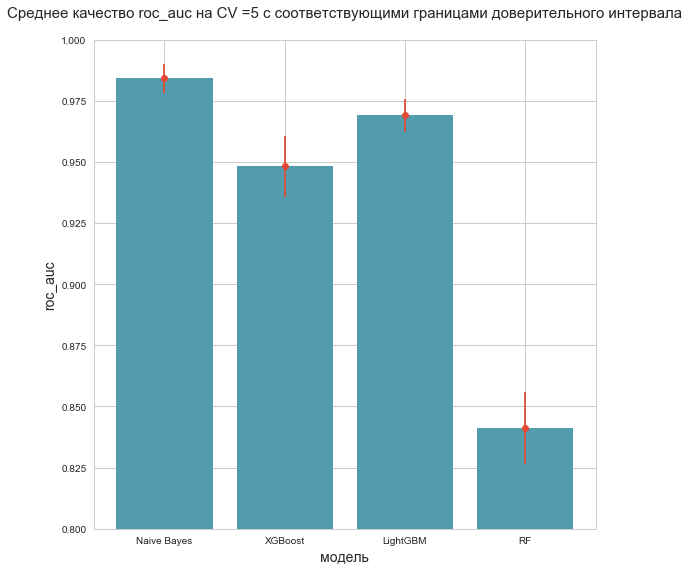

In [89]:
scores_mean = [ 0.9841,   0.9482,  0.9691, 0.8411]
std = [0.005900, 0.0124,0.00669, 0.01479] 
model_names = [1,2,3,4 ]


plt.figure(figsize=(9,9))

plt.errorbar(x=model_names, 
             y=scores_mean, 
             yerr=std,
             fmt='o')

plt.bar(model_names, scores_mean, color = '#539caf', align = 'center')
plt.xticks((1, 2,3,4), ('Naive Bayes', 'XGBoost', 'LightGBM','RF'))
ylim(ymax=1) # adjust the max leaving min unchanged
ylim(ymin=0.8)

plt.xlabel('модель', fontsize=14)
plt.ylabel('roc_auc',  fontsize=14)
plt.title('Cреднее качество roc_auc на CV =5 с соответствующими границами доверительного интервала'+ '\n', fontsize=15)


In [ ]:
#### Таким образом, наилучший результат дал Multinomial Naive Bayes, построенный на матрице частотности слов Tf-Idf 
## со средним roc_auc= 0.9841

## Train test split and vizualize data

In [22]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Z, data.label_num.values, test_size = 0.3, random_state = 7)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

2850 1222


C:\Users\somarov\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
pred = clf.predict_proba(X_test)[:,1]
all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
all_pred.columns = ['true', 'prob']
all_pred.sort_values('prob', ascending=False, inplace=True)

In [30]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
y_true = all_pred['true']
recall = []
precision = []
score = []
roc_auc= []

#aa =np.sort(table.pred.unique())
aa = np.sort(all_pred['prob'].unique())
for i in range(0, len(aa), 10):
    f = lambda x: 1 if x >aa[i] else 0
    score.append(aa[i])
    y_pred = all_pred['prob'].map(f)
    g=recall_score(y_true, y_pred, average='binary')
    recall.append(g)
    p = precision_score(y_true, y_pred, average='binary')
    precision.append(p)
    f =roc_auc_score(y_true, y_pred)
    roc_auc.append(f)

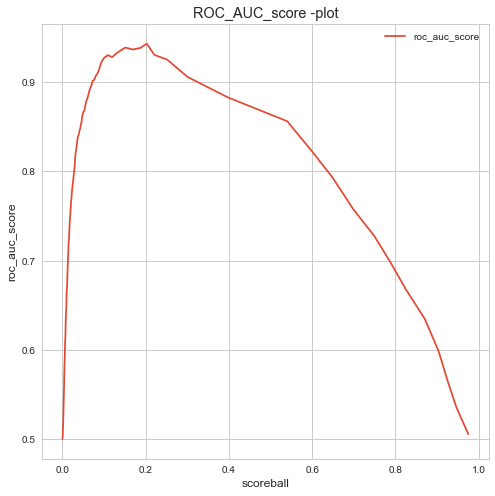

In [32]:
from matplotlib.pyplot import *
%matplotlib inline
style.use('ggplot')
sns.set_style("whitegrid")
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(8,8))
plt.grid(True)
#plt.plot(score, recall, 'o-', label="Полнота")
plt.plot(score, roc_auc, label="roc_auc_score")
#max_i = acc_score.loc[acc_score['accuracy_score'] ==acc_score['accuracy_score'].max(), 'score'].values
#max_j = acc_score.loc[acc_score['accuracy_score'] ==acc_score['accuracy_score'].max(), 'accuracy_score'].values
#plt.axvline(x= max_i, color='k', linestyle='--')
plt.xlabel('scoreball')
plt.ylabel('roc_auc_score')
plt.title('ROC_AUC_score -plot')
plt.legend()

#plt.text(max_i,max_j, '   ' + str(np.around(max_i, 4).tolist())  + '  '+ str(np.round(max_j, 4).tolist()), fontsize=10)
sns.plt.legend()

In [33]:
## Находим скорбалл, на котором достигается максимум accuracy
acc_score = pd.DataFrame(np.vstack([score, roc_auc]).T)
acc_score.columns = ['score', 'roc_auc_score']
acc_score.loc[acc_score['roc_auc_score'] ==acc_score['roc_auc_score'].max(), 'score'].values

array([ 0.2025955])

In [35]:
accuracy_score(all_pred['true'], all_pred['prob'].map(lambda x: 1 if x >0.2025955 else 0).tolist())

0.97135842880523726

## Vizualization

##### Попробуем визуализировать данные на плоскости для наглядности. Пробуем методы понижения размерности на плоскость - MDS и TSNE

In [57]:
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(X_test)

Populating the interactive namespace from numpy and matplotlib


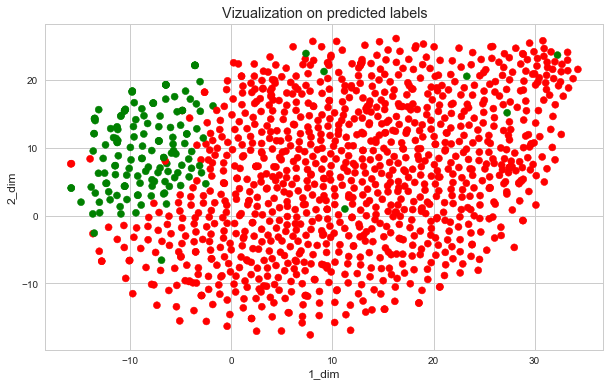

In [90]:
## Посмотрим, насколько хорошо отделяются сообщения spam от ham на one-hold выборке(y_predicted как маркеровка)
%pylab inline
pylab.figure(figsize = (10, 6))
colors = ['red','green']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on predicted labels')
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c =[1 if x>0.25138892 else 0 for x in pred], cmap=matplotlib.colors.ListedColormap(colors) )

Populating the interactive namespace from numpy and matplotlib


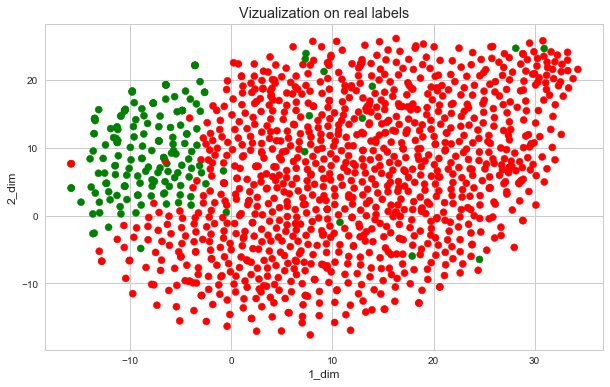

In [91]:
## Посмотрим, насколько хорошо отделяются сообщения spam от ham на one-hold выборке(y_test как маркеровка)
%pylab inline
pylab.figure(figsize = (10, 6))
colors = ['red','green']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on real labels')
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c =y_test, cmap=matplotlib.colors.ListedColormap(colors) )

In [59]:
## Видно, что результаты отделения ham от spam при понижении размерности неплохие- spam выделился в отдельный сектор.
## Попробуем MDS

In [60]:
mds = manifold.MDS(n_components = 2, n_init = 1, max_iter = 100)
data_2d_mds = mds.fit_transform(X_test)

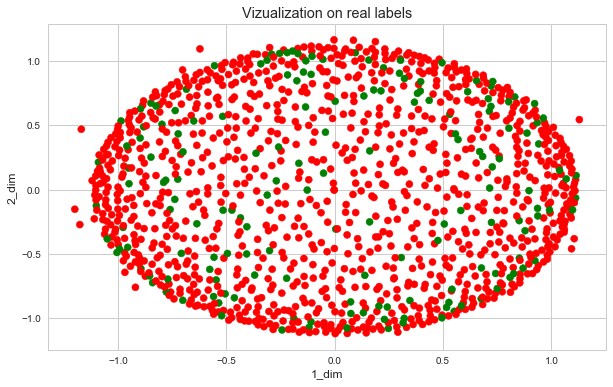

In [87]:
pylab.figure(figsize=(10, 6))
colors = ['red','green']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on real labels')
pylab.scatter(data_2d_mds[:, 0], data_2d_mds[:, 1],  c =y_test, cmap=matplotlib.colors.ListedColormap(colors))


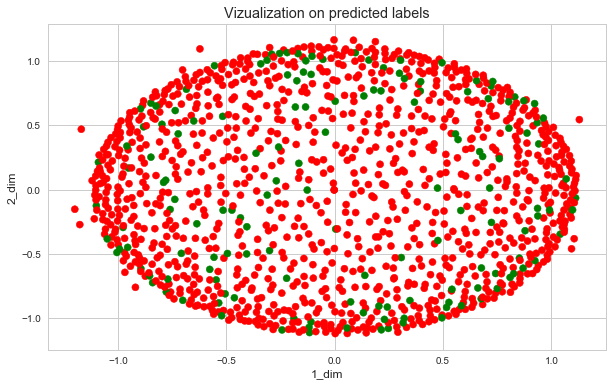

In [85]:
pylab.figure(figsize=(10, 6))
colors = ['red','green']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on predicted labels')
pylab.scatter(data_2d_mds[:, 0], data_2d_mds[:, 1],  c =[1 if x>0.25138892 else 0 for x in pred], cmap=matplotlib.colors.ListedColormap(colors))


##### Лучшее разделение на двумерную плоскость производит TSNE. В данном случае при решении задачи понижения размерности с помощью TSNE можно легко сформировать разделяющую поверхность для классификации spam от ham с помощью алгоритмов, строящихся на деревьях

## Prediction on test set

In [25]:
data_test = pd.read_csv("X_test.csv",encoding='cp1251', sep =',')

In [26]:
data_test = data_test.rename(columns={ "v1":"text"})

In [27]:
data_test['text_transf'] = data_test['text'].map(preprocess)

In [28]:
data_test['text_transf'] = data_test['text_transf'].map(preprocess_stem)

In [29]:
data_test['length'] = data_test['text_transf'].apply(len)

len_sms = data_test['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 


X_test_df = vect.transform(data_test['text'])
X_test_df = np.hstack((X_test_df.todense(),len_sms[:, None]))

In [30]:
pred_test = clf.predict_proba(X_test_df)[:,1]

In [31]:
data_test['label'] = pred_test
data_test['label'] = data_test['label'].map(lambda x: 'spam' if x >0.2025955 else 'ham')


In [32]:
data_test.drop('length',axis= 1, inplace=True)

In [34]:
data_test.drop('text_transf', axis=1, inplace=True)

In [35]:
data_test.to_csv('test_spam_detection.csv', sep = ',',index=False)